# Welcome to the Machine Learning exercise of the CMS Data Analysis School 2020 

Before we start with the actual exercise, the software as well as the notebook itself need to be set up.

To do this, please **execute the following five code cells**. Especially the first one might need a few minutes to complete, so grab a ☕️ or a beverage of your choice, and already start reading through the introduction.

**And most importantly, have fun 🎉!**

In [1]:
# setup some directories and install newest software on SWAN (TensorFlow 2.3 etc)
# note: you can ignore warnings about version incompatibilities
!$PWD/setup.sh fresh

environment successfully set up


In [2]:
# setup notebook extensions (cell splitting and presentation mode)
!jupyter nbextension enable splitcell/splitcell
!jupyter nbextension enable rise/main

Enabling notebook extension splitcell/splitcell...
      - Validating: OK
Enabling notebook extension rise/main...
      - Validating: OK


**Now, reload the page for extensions to become active!**

In [3]:
# update the sys.path to prefer custom software
import os
import sys

pyv = f"{sys.version_info.major}.{sys.version_info.minor}"
sys.path.insert(0, os.path.abspath(f"software/lib/python{pyv}/site-packages"))

To verify that the setup worked, you can checkout the version of the TensorFlow package.

If it's `2.3.0`, everything worked fine. If not, please [contact the exercise facilitators](https://discord.com/channels/720916736983171133/745610366012227606) (see instructions on introduction slides).

In [4]:
# check the tf version
import tensorflow as tf
print(tf.__version__)

2.3.0


In [5]:
# load custom css to make plots centered and the presentation mode prettier
from IPython.core.display import HTML
css_file = "assets/notebook_styles.css"
HTML("<style>{}</style>".format(open(css_file, "r").read()))

### Presentation mode

Now that everything is up and running, you can proceed with the exercise below.

If you want, you can also switch into **presentation** mode by clicking on the small button with the bar chart icon labelled "Enter/Exit RISE Slideshow" in the task bar above.

**Note**: If the button does not show up, you might need to reload the page once to setup newly enabled notebook extensions.

# CMSDAS 2020 - Machine Learning Exercise

<br />
<br />
<img src="assets/boosted_top_decay.png" />

- Facilitators
  - [Marcel Rieger](mailto:marcel.rieger@cern.ch?subject=CMSDAS%20ML%20Exercise) (CERN)
  - [Thea Åarrestad](mailto:thea.aarrestad@cern.ch?subject=CMSDAS%20ML%20Exercise) (CERN)
  - [Oleg Filatov](mailto:oleg.filatov@cern.ch?subject=CMSDAS%20ML%20Exercise) (DESY)
  - [Jan Kieseler](mailto:jan.kieseler@cern.ch?subject=CMSDAS%20ML%20Exercise) (CERN)
  - [Shah Rukh Qasim](mailto:shah.rukh.qasim@cern.ch?subject=CMSDAS%20ML%20Exercise) (CERN)

- Get in touch:
  - [Discord channel](https://discord.com/channels/720916736983171133/745610366012227606)

- Resources:
  - [Twiki page](https://twiki.cern.ch/twiki/bin/viewauth/CMS/SWGuideCMSDataAnalysisSchoolCERN2020MLShortExercise)
  - [Repository](https://github.com/riga/cmsdas2020_ml)

# Introduction

Our case study will be that of discriminating between jets produced by a hadronically decaying top quark which hadronizes, to jets produced by a light flavour quark or a gluon.

If the top quark has a very high transverse momentum, the decay products of the top (one b jet and two quark jets stemming from the decaying W boson), will be merged into one single large jet, which is referred to as a **top jet**. Potentially, this jet can exhibit three distinct, resolvable *sub jets*, whereas a light quark or gluon jet only appears as one single, large jet without any significant substructure.

The different appearance of these jets can be used as a handle to discriminate between them.  Being able to correctly identify top jets, and tell them apart from the overwhelming background of other light-flavored jets, is extremely important for many reasons.

Since the top quark is so heavy, being the only fermion we know of with a mass on the order of the weak scale, several extensions of the Standard Model which attempt to solve the hierarchy problem predict large couplings of new, hitherto unobserved particles to top quarks. Weeding top quark jets out of the ocean of other jets is therefore crucial for many **New Physics** searches!

<center><img src="assets/top_vs_qcd.png" width="60%"/></center>

## Aim and scope of the exercise

As motivated above, the target of this exercise is to identify jets originating from top quark decays (**top jets**) over a background of highly energetic **light jets**, i.e. jets emerging from light *up*, *down*, or *strange* quarks as well as gluons. Events involving mostly QCD interactions are a typical production mechanism.

You are given a dataset with information on > 1M jets, containing **kinematic observables** as well a **truth** label (a float value, either 0 or 1) that describes the origin of the jet. You can find more information on the input data in the cells below.

**Your task is to create a neural (NN) network model that, given a jet, uses its kinematic observables as input features to predict its most probable origin!**

In an **extension** of the exercise, you can learn how to build a NN that serves multiple purposes at the same time. We will try to let the model also predict the four-vector of the initial quark - the actual physics object we are interested in for reconstructing the underlying hard interaction.

Also, if you feel competitive 💪, it will be possibility to compare results of your trained model with other participants. Don't hesitate to get in touch through the [discord channel](https://discord.com/channels/720916736983171133/745610366012227606).

The **main aim** of this exercise is not to write a perfectly working model that is tailored for one specific use case, but rather to introduce you to some of the fundamental concepts that are used in machine learning applications today. Although we cannot meet, learn and discuss in person, try to collaborate and share ideas, thoughts and issues with others. Being able to *talk* about complex and abstract machine learning concepts is another important goal of this exercise.

## NN terminology

Before we dive in, let's quickly introduce a minimal set of NN terminology. Please note that a full introduction into machine learning would be too exhaustive at this point. For more insights, browse through the ML tutorial slides linked on the [Twiki page](https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideCMSDataAnalysisSchoolCERN2020MLShortExercise) or checkout one of the many resources that are publically available. A well written introduction that even includes code examples and interactive visualizations is this free online book at [neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com).

<center><img src="assets/nn_graph.png" width="60%"/></center>

- NNs are structured into so-called **layers** that contain **units**.
- We denote the **input layer** with $l = 0$, and the **output layer** with $l = L$.
- When the number of input features we give to the network is $N$, then the input layer will have $N$ units.
- The grey circles in the graph denote **bias units**. Their value is always one to allow for some numeric independence (see below).
- These $N$ input values are **forward passed** to layer $l = 1$. We do not intend to directly feed values into it, nor do we manually extract its output values - hence we call it **hidden layer**.
- The forward pass involves **weights** - these are free parameters, which are updated during training, and can be understood as *fit parameters*. NNs with O(100k) parameters are not uncommon!
- The input to the *i-th* unit in layer $l = 1$, $z_i^l$, is simply the scalar product of the vector of input features and a vector of weights $W_{ij}^{l-1}$,
\begin{align}
z_i^l &= \sum_j W_{ij}^{l-1} \cdot a_j^{l-1} + b_i^{l-1}\\
\Rightarrow z^l &= W^{l-1} \cdot a^{l-1} + b^{l-1}
\end{align}
where the bias unit is considered as an additional input with value 1, multiplied by the weight $b_j^{l-1}$. Each particular value of $W_{ij}^{l-1}$ and $b_j^{l-1}$ is represented by arrows in the diagram. The second line uses a **vectorized formulation** over all $1 \leq j \leq N$ inputs.
- The output $a_i^l$ of this unit is the value of an [**activation** function](https://en.wikipedia.org/wiki/Activation_function) $\sigma$, evaluated at its input $z_i^l$. This reads
$$
\begin{align}
a^l = \sigma^l(z^l) = \sigma_l(W^{l-1} \cdot a^{l-1} + b^{l-1})
\end{align}
$$
in the vectorial form. The same function is applied to all units in the same layer.
- Just like what we did with the input features, these output values can be propagated through the entire network up to the output layer $l = L$. Here, we choose a clever activation function to output the response $y$ that we like the network to learn (more on this later).
- As a whole, we can see the network output $y$ as a function of $x$, given $W$ and $b$. Thus, we can write
$$
\begin{align}
y = y(x | \underbrace{W,b}_{\equiv\ \omega}) = \underbrace{(a^L \circ a^{L-1} \circ \dots \circ a^1)_\omega}_\text{model} (x)
\end{align}
$$
and identify the **model** as the concatenation of all layers given the free parameters $\omega$.
- Besides the clear mathematical construction and rules to perform the forward pass, you might notice some *room for choices*, such as the number of hidden layers, the amount of units per layer, or the activation functions. These are called **hyper-parameters** and it is your task to understand your input data as well as the problem you want to solve, and adjust these parameters in a educated fashion to optimize the network performance.
- It is this exploration of the huge **space** of hyper-parameters what makes working with NNs complex and exciting at the same time 🎭!

## Training, overtraining and data splitting

### Network training

A comprehensive desription and explanantion of the *art* of NN training requires a collection of concepts and mathematical proofs that would by far reach beyond the scope of this short exercise. However, if you intend to apply machine learning techniques in the future, it is **highly recommended** to dive into this fascinating topic. Especially the formulation and proof of the **backpropagation** algorithm is of major importance as it paved the way of actual **deep** neural networks! A good place to start is the free online book at [neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com).

### Overtraining

During training, a NN receives *examples* in the form of vectors of input features and produces a prediction which can be compared to the *true* value one would expect. Based on the difference between prediction and expectation (in whatever way *difference* is defined), the network receives an either good or bad feedback that is used to update its trainable parameters, ideally leading to an improvement in the next iteration.

However, this process can have some caveats! When the amount of available training examples is very limited, chances are that they might not describe underlying probability distributions with sufficient precision. As a result, the NN might start to develop a bias towards this particular set of examples. Then, after the training phase, when the NN is requested to evaluate examples that it never *saw* before, its ability to infer predictions might differ greatly from what you observed during training. The model fails to **generalize**, which is referred to as **overtraining**.

### Data splitting

There are several techniques to monitor and prevent overtraining. One **mandatory** monitoring technique is data splitting. In its easiest form, the entirety of examples is split into three datasets:

- The *training* dataset is used for the actual training procedure.
- The *validation* dataset is **not** used **for** the training itself, but **during** the training to immediately monitor the NN's ability to generalize.
- All actual measurements are performed on an independent *testing* dataset.

This splitting is applied throughout this exercise!

# Training data

The input data consists of 1 million jets, originating from either
  - hadronically decaying top quarks (this is our **signal** ✔︎), or
  - dijet QCD events (our **background** ✘),
 
and clustered using the $k_{T}$ algorithm with $\Delta R$ = 0.8.

<br />

Data was generated using Phythia & Delphes, configured
  - to collide protons at 14 TeV center-of-mass energy,
  - to generate jets with a $p_{T}$ range of [550, 650] GeV (before hadronization ❗️), and
  - **without** mixing in pileup events for simplicity.

<center><img src="assets/top_vs_qcd.png" width="60%"/></center>

### Input features

Per jet, you are given the four-vectors of up to **200** of its *constituents* (i.e., the particles that form the jet by means of clustering).

   - These up to 800 values define your **input features**.
   - Note that not all jets have that many constituents❗️
   - To spare you the trouble of working with uneven (so-called *jagged*) arrays, these "missing" constituents vectors are filled with zeros.

### Training targets

Per jet, you are provided 2 different training targets:

  1. A flag that marks the true origin of the jet 
    - `1` for jets from top quark decays
    - `0` for light jets from QCD events
  2. The true four-vector of the initial particle (only for top quarks)
 
For now, we will focus on the **1.** training target to perform a *classification* to answer the question: **Top or not?**

(Spoiler: the second target is used later on to include an energy regression 🤫)

#### Hint

From now in, you might want to work *outside the presentation mode*.

### Diving into the data

Let's check out the data! It is stored in NumPy arrays across several files, with 50k jets per file. This way, prototyping and test runs are way quicker. You are given

- 20 training files (`"train"`)
- 8 validation files (`"valid"`)
- 8 testing files (`"test"`)

A few tools to perform recurrent tasks such as data loading are available in the dedicated `dasml` package. Let's import all packages we need during this exercise and load two training files and inspect the contents.

(you can neglect messages from matplotlib about creating the font cache)

In [6]:
# load the dasml package and other software
# (this might take a few seconds on SWAN)
import dasml
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
from tqdm.notebook import tqdm
import livelossplot as llp

In [7]:
# load the content of two "train" files
c_vectors, true_vectors, labels = dasml.data.load("train", start_file=0, stop_file=2)
c_vectors.shape, true_vectors.shape, labels.shape

((100000, 200, 4), (100000, 4), (100000,))

All arrays have 100k (2 x 50k) *rows* (dimension 0).

- Per jet, we have up to 200 constituents (`c_vectors`) with 4 variables ($E$, $p_x$, $p_y$, $p_z$) each, thus `(200, 4)`.
- Consistently, `true_vectors` only has 4 values per jet.
- The `labels`, however, are single values.

Let's create a few plots to get some insights into our data.

In [8]:
# define some flags to make four-vector element access more verbose
E, PX, PY, PZ = range(4)

In [9]:
# define a histogram helper
def plot_hist(arr, names=None, xlabel=None, ylabel="Entries", filename=None, legend_loc="upper center", **kwargs):
    kwargs.setdefault("bins", 20)
    kwargs.setdefault("alpha", 0.7)
   
    # consider multiple arrays and names given as a tuple
    arrs = arr if isinstance(arr, tuple) else (arr,)
    names = names or (len(arrs) * [""])

    # start plot
    fig, ax = plt.subplots()
    for arr, name in zip(arrs, names):
        bin_edges = ax.hist(arr, label=name, **kwargs)[1]
        kwargs["bins"] = bin_edges
    
    # legend
    if any(names):
        legend = ax.legend(loc=legend_loc)
        legend.get_frame().set_linewidth(0.0)
    
    # styles and custom adjustments
    ax.tick_params(axis="both", direction="in", top=True, right=True)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
 
    if filename:
        fig.savefig(filename)
    
    return fig

#### Truth distributions

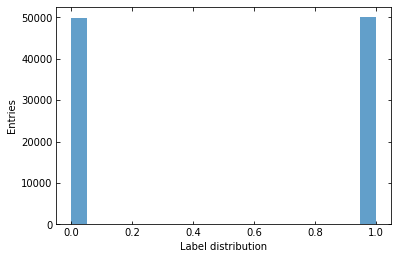

In [10]:
# distribution of truth labels
plot_hist(labels, xlabel="Label distribution").show()

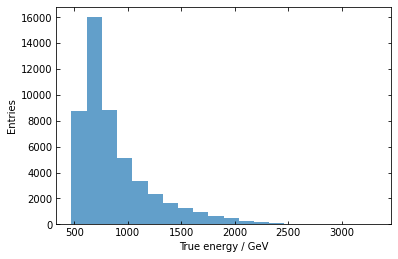

In [11]:
# energy distribution of the true top quark particle
# remember, this is only available for top jets (zero otherwise)
is_top = labels == 1
plot_hist(true_vectors[is_top, E], xlabel="True energy / GeV").show()

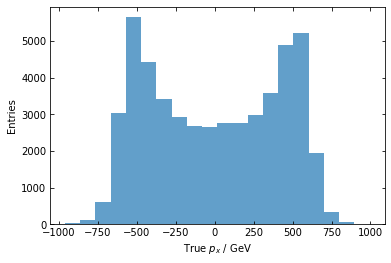

In [12]:
# px distribution of the true particle
plot_hist(true_vectors[is_top, PX], xlabel="True $p_x$ / GeV").show()

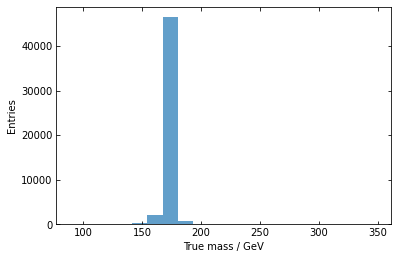

In [13]:
# mass distribution of the true particle
mass = (true_vectors[:, E]**2 - np.sum(true_vectors[:, PX:]**2, axis=1))**0.5 
plot_hist(mass[is_top], xlabel="True mass / GeV").show()

Yep, this is a top!

#### Input feature distributions

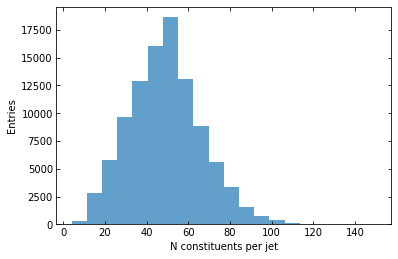

In [14]:
# number of constituents per jet
# remember, missing constituents are filled with zeros, so we take the energy value as a marker
n_c = np.count_nonzero(c_vectors[:, :, E], axis=1)
plot_hist(n_c, xlabel="N constituents per jet").show()

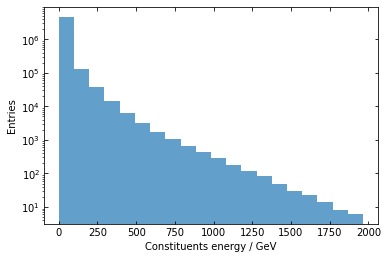

In [15]:
# energy distribution of all constituents
e_c = c_vectors[:, :, E].flatten()
# store a mask to remove zeros
non_zero = e_c != 0
plot_hist(e_c[non_zero], log=True, xlabel="Constituents energy / GeV").show()

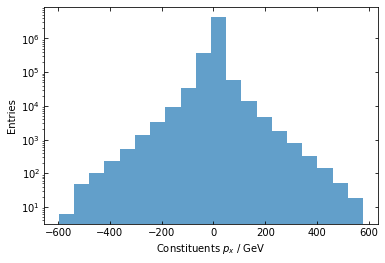

In [16]:
# px distribution of all constituents, zeros removed with the mask defined above
px_c = c_vectors[:, :, PX].flatten()
plot_hist(px_c[non_zero], log=True, xlabel="Constituents $p_x$ / GeV").show()

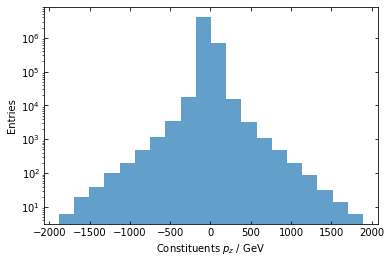

In [17]:
# pz distribution of all constituents
pz_c = c_vectors[:, :, PZ].flatten()
plot_hist(pz_c[non_zero], log=True, xlabel="Constituents $p_z$ / GeV").show()

### Lessons learned

Altough you were promised *up to* 200 constituents per jet, only a few of them seem to have more than 100 constituents!

Expect these *findings*, but don't interpret anything as bad intention 😉 The work packages of large-scale analysis are often shared and spread among multiple people, working groups and institutes. Staying on top of things is naturally a complex part, so communication and documentation is - as always - key!

Ok, so now that we understood the data, it would not make sense to include all these zeros in a network training. We can safely pick only the first, say, **120 constituents**.

# Quickshot: a minimal training and evaluation workflow

Before creating a full-blown training setup, let's first do a quickshot. This helps us to understand how a model is built, trained, and eventually evaluated. We can also already define a few plot methods to assess the performance.

For this purpose, we use TensorFlow with the Keras high level API in its [functional version](https://keras.io/guides/functional_api).

In [18]:
# first, we define a preprocessing function that (e.g.) takes the
# constiuents and returns an other representation of them
# in this case, we select only the first 120 constituents and
# flatten the resulting array from (..., 120, 4) to (..., 480,)
def preprocess_constituents(constituents):
    return constituents[:, :120].reshape((-1, 480))

In [19]:
# also, for the training we need to convert the label to a "one-hot" representation
# 0. -> [1., 0.]
# 1. -> [0., 1.]
def labels_to_onehot(labels):
    labels = labels.astype(np.int32)
    onehot = np.zeros((labels.shape[0], labels.max() + 1), dtype=np.float32)
    onehot[np.arange(labels.shape[0]), labels] = 1
    return onehot

In [20]:
# define the model generating function
# - 2 hidden layers
# - 128 units each
# - tanh activation
# - 2 output units with softmax activation
# (applies exp() to outputs and normalizes sum of all outputs to 1)
def create_model():
    x = tf.keras.Input(shape=(480,))
    a1 = tf.keras.layers.Dense(128, use_bias=True, activation="tanh")(x)
    a2 = tf.keras.layers.Dense(128, use_bias=True, activation="tanh")(a1)
    y = tf.keras.layers.Dense(2, use_bias=True, activation="softmax")(a2)
    return tf.keras.Model(inputs=x, outputs=y, name="toptagging_quickshot")

In [21]:
# create the actual model
model = create_model()
model.summary()

Model: "toptagging_quickshot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               61568     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 78,338
Trainable params: 78,338
Non-trainable params: 0
_________________________________________________________________


In [22]:
# let's see what happens when we call it with zeros
# note: here we create zeros with in the shape (1, 480)
# where the leading one marks the *batch size*,
# i.e. the number of examples that are simultaneously fed
# into the network to benefit from clever vectorization
t = model.predict(np.zeros((1, 480)))
t

array([[0.5, 0.5]], dtype=float32)

This produces a TensorFlow `Tensor` object - an [*eager*](https://www.tensorflow.org/guide/eager) tensor to be precise. It *almost* feels and behaves like a NumPy array, except for a few differences that you will stumble upon very soon on your own ...
To extract a true NumPy representation of its data, feel free to call `t.numpy()`. However, for writing performant, GPU compatible NNs, the use of the `Tensor` API is mandatory.

The return value is `[0.5, 0.5]`. This means that, given a vector of input features consisting only of zeros, the network is unsure whether to assign it to the signal class (top jets) nor to the background class (light jets). This is totally reasonable as we haven't trained it yet. So let's do that!

In [23]:
# load more training, and also validation data
c_vectors_train, _, labels_train = dasml.data.load("train", stop_file=6)
c_vectors_valid, _, labels_valid = dasml.data.load("valid", stop_file=3)

# run the preprocessing
c_vectors_train = preprocess_constituents(c_vectors_train)
c_vectors_valid = preprocess_constituents(c_vectors_valid)

# create one-hot labels
labels_train = labels_to_onehot(labels_train)
labels_valid = labels_to_onehot(labels_valid)

In [24]:
# compile the model
# this means that the internal computational graph structure is built,
# the loss function (the function that provides the feedback by comparing
# expected and predicted result, more on that later), and metrics are
# registered that are shown during the training
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

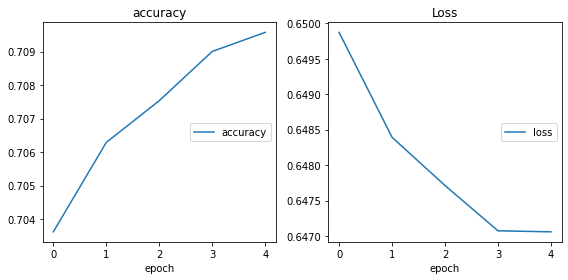

1500/1500 [==============================] - 7s 5ms/step - loss: 0.6471 - accuracy: 0.7096


In [25]:
# start the training for 5 epochs (running through all data 5 times)
model.fit(
    c_vectors_train,
    labels_train,
    batch_size=200,
    epochs=5,
    callbacks=[llp.PlotLossesKerasTF(outputs=[llp.outputs.MatplotlibPlot(cell_size=(4, 2))])],
)

We ended up with an accuracy of about 70%, which is already quite good for such a small network (and lot's of important things we did not even consider yet ...)!

Let's check if the model generalized by evaluating the validation data and manually computing the accuracy.

In [26]:
# evaluate all training and validation data again for ruther study
predictions_train = model.predict(c_vectors_train)
predictions_valid = model.predict(c_vectors_valid)

In [27]:
# determine the accuracy
def calculate_accuracy(labels, predictions):
    # while the labels (NumPy array) are one-hot encoded,
    # each prediction (TF tensor) consists of two numbers whose sum is 1,
    # so we interpret the prediction to be the signal when the second value (index 1) is > 0.5
    # hence, we can use argmax
    predicteds_top = np.argmax(predictions, axis=-1) == 1
    labels_top = labels[:, 1] == 1
    return (predicteds_top == labels_top).mean()

In [28]:
acc_train = calculate_accuracy(labels_train, predictions_train)
acc_valid = calculate_accuracy(labels_valid, predictions_valid)

print(f"train accuracy: {acc_train:.4f}")
print(f"valid accuracy: {acc_valid:.4f}")

train accuracy: 0.7112
valid accuracy: 0.7132


This looks fairly similar, so for now, we don't seem to experience overtraining.

We proceed by taking a look at the output distributions of the validation dataset, separated into signal and background components. Since we are dealing with a binary classification, and the sum of the two output values is normalized to one, it is sufficient to inspect just one of the output nodes. Since our goal is to identify signal, we look at the second column with index 1 (note that the same is considered in the accuracy calculation above).

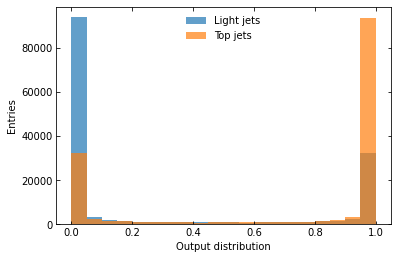

In [29]:
plot_hist(
    (predictions_valid[labels_valid == 0], predictions_valid[labels_valid == 1]),
    names=("Light jets", "Top jets"),
    xlabel="Output distribution",
).show()

Besides the classification accuracy, we can study the *receiver operating characteristic* curve or **ROC** curve. It shows the relation between the true positive (jets *correctly* identified as top jets) and false positive rates (light jets *mistaken* as a top jets).

In [30]:
# helper to draw a ROC curve
def plot_roc(labels, predictions, names=None, xlim=(0.01, 1), ylim=(1, 1e2)):   
    # start plot
    fig, ax = plt.subplots()
    ax.set_xlabel("True positive rate")
    ax.set_ylabel("1 / False positive rate")
    ax.set_yscale("log")
    ax.tick_params(axis="both", direction="in", top=True, right=True)
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim(left=xlim[0], right=xlim[1])
    ax.set_ylim(bottom=ylim[0], top=ylim[1])
    plots = []

    # treat labels and predictions as tuples
    labels = labels if isinstance(labels, tuple) else (labels,)
    predictions = predictions if isinstance(predictions, tuple) else (predictions,)
    names = names or (len(labels) * [""])
    for l, p, n in zip(labels, predictions, names):
        # linearize
        l = l[:, 1]
        p = p[:, 1]

        # create the ROC curve and get the AUC
        fpr, tpr, _ = roc_curve(l, p)
        auc = roc_auc_score(l, p)
        
        # apply lower x limit to prevent zero division warnings below
        fpr = fpr[tpr > xlim[0]]
        tpr = tpr[tpr > xlim[0]]

        # plot
        plot_name = (n and (n + ", ")) + "AUC {:.3f}".format(auc)
        plots.extend(ax.plot(tpr, 1. / fpr, label=plot_name))

    # legend
    legend = ax.legend(plots, [p.get_label() for p in plots], loc="upper right")
    legend.get_frame().set_linewidth(0.0)

    return fig

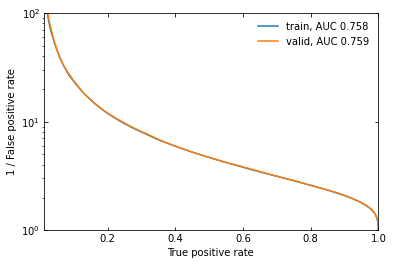

In [31]:
# do the roc plot
plot_roc(
    (labels_train, labels_valid),
    (predictions_train, predictions_valid),
    names=("train", "valid"),
).show()

The curves above are produced by scanning potential values to cut on the network output and examining the resulting signal classification (true positive) and background mis-classification (false positive) rates.

Naturally, a well performing network has a high true positive rate while keeping the (reciprocal) false positive rate at a reasonably low (high) level. For the choice of the axes above, this would lead to a curve that is bent towards the upper right corner. But be aware that other representations of the ROC curve exist which might look somewhat different (e.g. "1 - false positive rate" on the y-axis). Their message is, however, identical.

A commonly used proxy that compiles the values for all possible cuts into one metric is the area-under-curve - **AUC**. A value of 1 signalizes a perfectly working network that allows for a cut value leading to 100% signal efficiency and 0% background contamination. Opposed to that, a value of 0.5 means that the two output distributions of signal and background events are probably fully overlapping, lacking the opportunity to apply a cut that would favor signal examples. A value of 0 has the same logical meaning as 1, but the definition of what is signal and background is flipped. Therefore, the distance from 0.5 is what actually matters here.

A value around 0.75 is already quite decent, but there's still potential. You can try to beat this value in the full training setup below.

### Lessons learned

- Now we know how to build a simple model using TensorFlow and Keras.
- We learned how to one-hot encode labels.
- We performed a quick training using the `fit()` method of Keras models.
- To ensure model generalization, we evaluated validation data with our trainined model.
- We calculated accuracies and visualized the output distributions.
- We learned about ROC curves, AUC values and how to plot / compute them.

With these tools at hand, we can jump into the next section and build a custom training loop.

# Training++

To get more insights into the actual neural network training process, we will use Keras only to compose the model. For preprocessing, the definition of losses, and the training loop, we will use bare TensorFlow operations and tools.

Also, we reconsider some of the choices we made above and incorporate a few techniques that improve the network training.

Here are a few TensorFlow resources that might help you in the process:

- [Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
- [Loading NumPy data](https://www.tensorflow.org/tutorials/load_data/numpy)
- [Keras layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)
- [Eager execution](https://www.tensorflow.org/guide/eager)
- [Gradient tape and differentiation](https://www.tensorflow.org/guide/autodiff)
- [Graphs and introduction to `tf.function`](https://www.tensorflow.org/guide/intro_to_graphs)
- [Better performance with `tf.function`](https://www.tensorflow.org/guide/function)
- [Training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)
- [TensorFlow 2 tutorial held at CERN](https://indico.cern.ch/event/882992/contributions/3721506/attachments/1994721/3327402/TensorFlow_2_Workshop_CERN_2020.pdf)

### Eager execution and graphs

Just like with NumPy, we can interactively work with TensorFlow tensors. Each operation is executed *eagerly* as soon as the interpreter reaches and evaluates that line.

In [32]:
t = tf.range(0., 10.)
print(t)
t = t * 2
print(t)
t = t + 1
print(t)

tf.Tensor([0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], shape=(10,), dtype=float32)
tf.Tensor([ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.], shape=(10,), dtype=float32)
tf.Tensor([ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.], shape=(10,), dtype=float32)


Actually, one might not be interested in intermediate results so the outcome of `t = t * 2` in line 3 is perhaps not required. Also, imagine the operation `(t * 2) + 1` is executed on a GPU. The content of `t` - not that many bytes in this example, but tensors can easily reach a couple MBs - is transferred to the GPU, together with the instructions to multiply each value by 2 and then adding 1. The output of this computation is sent back to the CPU where (e.g.) the Python interpreter can print the numbers as done in line 6.

There is obviously no need to send back the result of `t * 2`. However, this is exactly what would happen in the example above. While this is a nice and intuitive way to prototype a new model, we somehow need a way to tell TensorFlow to compute a set of instructions as a whole, and that we are only interested in the final result. This is where **graphs** enter the equation.

A computational graph describes the symbolic instructions that should be performed on certain input tensors (orange) to produce the result of a complex computation. These instructions are represented by `tf.Operation` objects (green), while the data flowing between them is contained in `tf.Tensor`'s (purple). The graph of the computation above would look like this:

[![](https://mermaid.ink/img/eyJjb2RlIjoiZ3JhcGggTFJcbkFbcmFuZ2UgMCAtIDEwXVxuQltjb25zdGFudCAyXVxuQ1tjb25zdGFudCAxXVxuTXttdWx9XG5Oe2FkZH1cbkRbdCddXG5FW3QnJ11cbkEgJiBCIC0tPiBNXG5NIC0tPiBEXG5EICYgQyAtLT4gTlxuTiAtLT4gRVxuc3R5bGUgQSBmaWxsOiNmOTZcbnN0eWxlIEIgZmlsbDojZjk2XG5zdHlsZSBDIGZpbGw6I2Y5Nlxuc3R5bGUgTSBmaWxsOiNiZGFcbnN0eWxlIE4gZmlsbDojYmRhIiwibWVybWFpZCI6eyJ0aGVtZSI6ImRlZmF1bHQiLCJ0aGVtZVZhcmlhYmxlcyI6eyJiYWNrZ3JvdW5kIjoid2hpdGUiLCJwcmltYXJ5Q29sb3IiOiIjRUNFQ0ZGIiwic2Vjb25kYXJ5Q29sb3IiOiIjZmZmZmRlIiwidGVydGlhcnlDb2xvciI6ImhzbCg4MCwgMTAwJSwgOTYuMjc0NTA5ODAzOSUpIiwicHJpbWFyeUJvcmRlckNvbG9yIjoiaHNsKDI0MCwgNjAlLCA4Ni4yNzQ1MDk4MDM5JSkiLCJzZWNvbmRhcnlCb3JkZXJDb2xvciI6ImhzbCg2MCwgNjAlLCA4My41Mjk0MTE3NjQ3JSkiLCJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjoiaHNsKDgwLCA2MCUsIDg2LjI3NDUwOTgwMzklKSIsInByaW1hcnlUZXh0Q29sb3IiOiIjMTMxMzAwIiwic2Vjb25kYXJ5VGV4dENvbG9yIjoiIzAwMDAyMSIsInRlcnRpYXJ5VGV4dENvbG9yIjoicmdiKDkuNTAwMDAwMDAwMSwgOS41MDAwMDAwMDAxLCA5LjUwMDAwMDAwMDEpIiwibGluZUNvbG9yIjoiIzMzMzMzMyIsInRleHRDb2xvciI6IiMzMzMiLCJtYWluQmtnIjoiI0VDRUNGRiIsInNlY29uZEJrZyI6IiNmZmZmZGUiLCJib3JkZXIxIjoiIzkzNzBEQiIsImJvcmRlcjIiOiIjYWFhYTMzIiwiYXJyb3doZWFkQ29sb3IiOiIjMzMzMzMzIiwiZm9udEZhbWlseSI6IlwidHJlYnVjaGV0IG1zXCIsIHZlcmRhbmEsIGFyaWFsIiwiZm9udFNpemUiOiIxNnB4IiwibGFiZWxCYWNrZ3JvdW5kIjoiI2U4ZThlOCIsIm5vZGVCa2ciOiIjRUNFQ0ZGIiwibm9kZUJvcmRlciI6IiM5MzcwREIiLCJjbHVzdGVyQmtnIjoiI2ZmZmZkZSIsImNsdXN0ZXJCb3JkZXIiOiIjYWFhYTMzIiwiZGVmYXVsdExpbmtDb2xvciI6IiMzMzMzMzMiLCJ0aXRsZUNvbG9yIjoiIzMzMyIsImVkZ2VMYWJlbEJhY2tncm91bmQiOiIjZThlOGU4IiwiYWN0b3JCb3JkZXIiOiJoc2woMjU5LjYyNjE2ODIyNDMsIDU5Ljc3NjUzNjMxMjglLCA4Ny45MDE5NjA3ODQzJSkiLCJhY3RvckJrZyI6IiNFQ0VDRkYiLCJhY3RvclRleHRDb2xvciI6ImJsYWNrIiwiYWN0b3JMaW5lQ29sb3IiOiJncmV5Iiwic2lnbmFsQ29sb3IiOiIjMzMzIiwic2lnbmFsVGV4dENvbG9yIjoiIzMzMyIsImxhYmVsQm94QmtnQ29sb3IiOiIjRUNFQ0ZGIiwibGFiZWxCb3hCb3JkZXJDb2xvciI6ImhzbCgyNTkuNjI2MTY4MjI0MywgNTkuNzc2NTM2MzEyOCUsIDg3LjkwMTk2MDc4NDMlKSIsImxhYmVsVGV4dENvbG9yIjoiYmxhY2siLCJsb29wVGV4dENvbG9yIjoiYmxhY2siLCJub3RlQm9yZGVyQ29sb3IiOiIjYWFhYTMzIiwibm90ZUJrZ0NvbG9yIjoiI2ZmZjVhZCIsIm5vdGVUZXh0Q29sb3IiOiJibGFjayIsImFjdGl2YXRpb25Cb3JkZXJDb2xvciI6IiM2NjYiLCJhY3RpdmF0aW9uQmtnQ29sb3IiOiIjZjRmNGY0Iiwic2VxdWVuY2VOdW1iZXJDb2xvciI6IndoaXRlIiwic2VjdGlvbkJrZ0NvbG9yIjoicmdiYSgxMDIsIDEwMiwgMjU1LCAwLjQ5KSIsImFsdFNlY3Rpb25Ca2dDb2xvciI6IndoaXRlIiwic2VjdGlvbkJrZ0NvbG9yMiI6IiNmZmY0MDAiLCJ0YXNrQm9yZGVyQ29sb3IiOiIjNTM0ZmJjIiwidGFza0JrZ0NvbG9yIjoiIzhhOTBkZCIsInRhc2tUZXh0TGlnaHRDb2xvciI6IndoaXRlIiwidGFza1RleHRDb2xvciI6IndoaXRlIiwidGFza1RleHREYXJrQ29sb3IiOiJibGFjayIsInRhc2tUZXh0T3V0c2lkZUNvbG9yIjoiYmxhY2siLCJ0YXNrVGV4dENsaWNrYWJsZUNvbG9yIjoiIzAwMzE2MyIsImFjdGl2ZVRhc2tCb3JkZXJDb2xvciI6IiM1MzRmYmMiLCJhY3RpdmVUYXNrQmtnQ29sb3IiOiIjYmZjN2ZmIiwiZ3JpZENvbG9yIjoibGlnaHRncmV5IiwiZG9uZVRhc2tCa2dDb2xvciI6ImxpZ2h0Z3JleSIsImRvbmVUYXNrQm9yZGVyQ29sb3IiOiJncmV5IiwiY3JpdEJvcmRlckNvbG9yIjoiI2ZmODg4OCIsImNyaXRCa2dDb2xvciI6InJlZCIsInRvZGF5TGluZUNvbG9yIjoicmVkIiwibGFiZWxDb2xvciI6ImJsYWNrIiwiZXJyb3JCa2dDb2xvciI6IiM1NTIyMjIiLCJlcnJvclRleHRDb2xvciI6IiM1NTIyMjIiLCJjbGFzc1RleHQiOiIjMTMxMzAwIiwiZmlsbFR5cGUwIjoiI0VDRUNGRiIsImZpbGxUeXBlMSI6IiNmZmZmZGUiLCJmaWxsVHlwZTIiOiJoc2woMzA0LCAxMDAlLCA5Ni4yNzQ1MDk4MDM5JSkiLCJmaWxsVHlwZTMiOiJoc2woMTI0LCAxMDAlLCA5My41Mjk0MTE3NjQ3JSkiLCJmaWxsVHlwZTQiOiJoc2woMTc2LCAxMDAlLCA5Ni4yNzQ1MDk4MDM5JSkiLCJmaWxsVHlwZTUiOiJoc2woLTQsIDEwMCUsIDkzLjUyOTQxMTc2NDclKSIsImZpbGxUeXBlNiI6ImhzbCg4LCAxMDAlLCA5Ni4yNzQ1MDk4MDM5JSkiLCJmaWxsVHlwZTciOiJoc2woMTg4LCAxMDAlLCA5My41Mjk0MTE3NjQ3JSkifX0sInVwZGF0ZUVkaXRvciI6ZmFsc2V9)](https://mermaid-js.github.io/mermaid-live-editor/#/edit/eyJjb2RlIjoiZ3JhcGggTFJcbkFbcmFuZ2UgMCAtIDEwXVxuQltjb25zdGFudCAyXVxuQ1tjb25zdGFudCAxXVxuTXttdWx9XG5Oe2FkZH1cbkRbdCddXG5FW3QnJ11cbkEgJiBCIC0tPiBNXG5NIC0tPiBEXG5EICYgQyAtLT4gTlxuTiAtLT4gRVxuc3R5bGUgQSBmaWxsOiNmOTZcbnN0eWxlIEIgZmlsbDojZjk2XG5zdHlsZSBDIGZpbGw6I2Y5Nlxuc3R5bGUgTSBmaWxsOiNiZGFcbnN0eWxlIE4gZmlsbDojYmRhIiwibWVybWFpZCI6eyJ0aGVtZSI6ImRlZmF1bHQiLCJ0aGVtZVZhcmlhYmxlcyI6eyJiYWNrZ3JvdW5kIjoid2hpdGUiLCJwcmltYXJ5Q29sb3IiOiIjRUNFQ0ZGIiwic2Vjb25kYXJ5Q29sb3IiOiIjZmZmZmRlIiwidGVydGlhcnlDb2xvciI6ImhzbCg4MCwgMTAwJSwgOTYuMjc0NTA5ODAzOSUpIiwicHJpbWFyeUJvcmRlckNvbG9yIjoiaHNsKDI0MCwgNjAlLCA4Ni4yNzQ1MDk4MDM5JSkiLCJzZWNvbmRhcnlCb3JkZXJDb2xvciI6ImhzbCg2MCwgNjAlLCA4My41Mjk0MTE3NjQ3JSkiLCJ0ZXJ0aWFyeUJvcmRlckNvbG9yIjoiaHNsKDgwLCA2MCUsIDg2LjI3NDUwOTgwMzklKSIsInByaW1hcnlUZXh0Q29sb3IiOiIjMTMxMzAwIiwic2Vjb25kYXJ5VGV4dENvbG9yIjoiIzAwMDAyMSIsInRlcnRpYXJ5VGV4dENvbG9yIjoicmdiKDkuNTAwMDAwMDAwMSwgOS41MDAwMDAwMDAxLCA5LjUwMDAwMDAwMDEpIiwibGluZUNvbG9yIjoiIzMzMzMzMyIsInRleHRDb2xvciI6IiMzMzMiLCJtYWluQmtnIjoiI0VDRUNGRiIsInNlY29uZEJrZyI6IiNmZmZmZGUiLCJib3JkZXIxIjoiIzkzNzBEQiIsImJvcmRlcjIiOiIjYWFhYTMzIiwiYXJyb3doZWFkQ29sb3IiOiIjMzMzMzMzIiwiZm9udEZhbWlseSI6IlwidHJlYnVjaGV0IG1zXCIsIHZlcmRhbmEsIGFyaWFsIiwiZm9udFNpemUiOiIxNnB4IiwibGFiZWxCYWNrZ3JvdW5kIjoiI2U4ZThlOCIsIm5vZGVCa2ciOiIjRUNFQ0ZGIiwibm9kZUJvcmRlciI6IiM5MzcwREIiLCJjbHVzdGVyQmtnIjoiI2ZmZmZkZSIsImNsdXN0ZXJCb3JkZXIiOiIjYWFhYTMzIiwiZGVmYXVsdExpbmtDb2xvciI6IiMzMzMzMzMiLCJ0aXRsZUNvbG9yIjoiIzMzMyIsImVkZ2VMYWJlbEJhY2tncm91bmQiOiIjZThlOGU4IiwiYWN0b3JCb3JkZXIiOiJoc2woMjU5LjYyNjE2ODIyNDMsIDU5Ljc3NjUzNjMxMjglLCA4Ny45MDE5NjA3ODQzJSkiLCJhY3RvckJrZyI6IiNFQ0VDRkYiLCJhY3RvclRleHRDb2xvciI6ImJsYWNrIiwiYWN0b3JMaW5lQ29sb3IiOiJncmV5Iiwic2lnbmFsQ29sb3IiOiIjMzMzIiwic2lnbmFsVGV4dENvbG9yIjoiIzMzMyIsImxhYmVsQm94QmtnQ29sb3IiOiIjRUNFQ0ZGIiwibGFiZWxCb3hCb3JkZXJDb2xvciI6ImhzbCgyNTkuNjI2MTY4MjI0MywgNTkuNzc2NTM2MzEyOCUsIDg3LjkwMTk2MDc4NDMlKSIsImxhYmVsVGV4dENvbG9yIjoiYmxhY2siLCJsb29wVGV4dENvbG9yIjoiYmxhY2siLCJub3RlQm9yZGVyQ29sb3IiOiIjYWFhYTMzIiwibm90ZUJrZ0NvbG9yIjoiI2ZmZjVhZCIsIm5vdGVUZXh0Q29sb3IiOiJibGFjayIsImFjdGl2YXRpb25Cb3JkZXJDb2xvciI6IiM2NjYiLCJhY3RpdmF0aW9uQmtnQ29sb3IiOiIjZjRmNGY0Iiwic2VxdWVuY2VOdW1iZXJDb2xvciI6IndoaXRlIiwic2VjdGlvbkJrZ0NvbG9yIjoicmdiYSgxMDIsIDEwMiwgMjU1LCAwLjQ5KSIsImFsdFNlY3Rpb25Ca2dDb2xvciI6IndoaXRlIiwic2VjdGlvbkJrZ0NvbG9yMiI6IiNmZmY0MDAiLCJ0YXNrQm9yZGVyQ29sb3IiOiIjNTM0ZmJjIiwidGFza0JrZ0NvbG9yIjoiIzhhOTBkZCIsInRhc2tUZXh0TGlnaHRDb2xvciI6IndoaXRlIiwidGFza1RleHRDb2xvciI6IndoaXRlIiwidGFza1RleHREYXJrQ29sb3IiOiJibGFjayIsInRhc2tUZXh0T3V0c2lkZUNvbG9yIjoiYmxhY2siLCJ0YXNrVGV4dENsaWNrYWJsZUNvbG9yIjoiIzAwMzE2MyIsImFjdGl2ZVRhc2tCb3JkZXJDb2xvciI6IiM1MzRmYmMiLCJhY3RpdmVUYXNrQmtnQ29sb3IiOiIjYmZjN2ZmIiwiZ3JpZENvbG9yIjoibGlnaHRncmV5IiwiZG9uZVRhc2tCa2dDb2xvciI6ImxpZ2h0Z3JleSIsImRvbmVUYXNrQm9yZGVyQ29sb3IiOiJncmV5IiwiY3JpdEJvcmRlckNvbG9yIjoiI2ZmODg4OCIsImNyaXRCa2dDb2xvciI6InJlZCIsInRvZGF5TGluZUNvbG9yIjoicmVkIiwibGFiZWxDb2xvciI6ImJsYWNrIiwiZXJyb3JCa2dDb2xvciI6IiM1NTIyMjIiLCJlcnJvclRleHRDb2xvciI6IiM1NTIyMjIiLCJjbGFzc1RleHQiOiIjMTMxMzAwIiwiZmlsbFR5cGUwIjoiI0VDRUNGRiIsImZpbGxUeXBlMSI6IiNmZmZmZGUiLCJmaWxsVHlwZTIiOiJoc2woMzA0LCAxMDAlLCA5Ni4yNzQ1MDk4MDM5JSkiLCJmaWxsVHlwZTMiOiJoc2woMTI0LCAxMDAlLCA5My41Mjk0MTE3NjQ3JSkiLCJmaWxsVHlwZTQiOiJoc2woMTc2LCAxMDAlLCA5Ni4yNzQ1MDk4MDM5JSkiLCJmaWxsVHlwZTUiOiJoc2woLTQsIDEwMCUsIDkzLjUyOTQxMTc2NDclKSIsImZpbGxUeXBlNiI6ImhzbCg4LCAxMDAlLCA5Ni4yNzQ1MDk4MDM5JSkiLCJmaWxsVHlwZTciOiJoc2woMTg4LCAxMDAlLCA5My41Mjk0MTE3NjQ3JSkifX0sInVwZGF0ZUVkaXRvciI6ZmFsc2V9)

To declare a computational graph, we can write a function and decorate it with `tf.function`.

In [33]:
@tf.function
def my_func(t):
    print("new graph created", t.dtype, t.shape)
    t = t * 2
    print(t)
    t = t + 1
    print(t)
    return t

t = tf.range(0., 10.)
my_func(t)

new graph created <dtype: 'float32'> (10,)
Tensor("mul:0", shape=(10,), dtype=float32)
Tensor("add:0", shape=(10,), dtype=float32)


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.], dtype=float32)>

As you can see, the output is exactly the same, but the intermediate tensors no longer have values attached to them. The first time we called `my_func` in line 10, a concrete graph was created that expects an input tensor with type `float32` and shape `(10,)`. In fact, when we repeat this call with an input tensor of identical type and shape, `my_func` is not even called, but TensorFlow uses the previously created graph and executes it.

In [34]:
my_func(tf.range(10., 20.))

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([21., 23., 25., 27., 29., 31., 33., 35., 37., 39.], dtype=float32)>

No line `new graph created ...` is printed, implying that `my_func` is indeed not called!

However, if we use a tensor with a different type or shape, a new graph is created and stored internally. This powerful feature is called **signature tracing** and you can read more about it [here](https://www.tensorflow.org/guide/function).

In [35]:
my_func(tf.range(10., 21.))
print("---")
my_func(tf.range(10, 20, dtype=tf.int32))

new graph created <dtype: 'float32'> (11,)
Tensor("mul:0", shape=(11,), dtype=float32)
Tensor("add:0", shape=(11,), dtype=float32)
---
new graph created <dtype: 'int32'> (10,)
Tensor("mul:0", shape=(10,), dtype=int32)
Tensor("add:0", shape=(10,), dtype=int32)


<tf.Tensor: shape=(10,), dtype=int32, numpy=array([21, 23, 25, 27, 29, 31, 33, 35, 37, 39], dtype=int32)>

With these concepts at hand, we can go ahead and start building our data pipeline!

### Data pipeline and preprocessing

Above, we created a method `preprocess_constituents` to select the first 120 constituents per jet and to merge the last two dimensions so that we can feed a NN that expects an input feature vector. This was sufficient as the `model.fit` method knows how to apply batching of input jets and how to repeat the dataset to train for more than one epoch.

Using plain TensorFlow, we use a `tf.data.Dataset` object for this purpose. Let's write a function that returns a dataset for our training.

But now, we include an important aspect of deep learning, namely **feature scaling** (FS)! To introduce FS, we first need to understand the concept of **numerical domains** in the context of NN applications.

Our input data - a selection of four-vectors with values given in GeV - clearly comes from the domain of physics. As we have seen in the plots above, their numerical values range from -500 to 500 for $p_x$ and $p_y$, and up to 2000 for $E$ and $p_z$ values. We can use the abstract term *application domain* to describe these ranges. However, the domain of numbers being passed back and forth through the network is entirely different and can even vary depending on the architecture you pick! A classical feed forward network, such as the one we created above, and a plentora of techniques that were developed throughout the last decade(s) prefer values to be in a range between, say, -1 and 1, and we can call it *network domain*. This is just an example and somewhat larger values are certainly fine as well. But still, you get the idea that numerical application and network domains are *entirely different*.

Numerically, the output of our *classification* model is still in the network domain and we simply interpret it as a binary classification decision, so we are safe on this end. Things get a bit more tricky when we perform a *regression* task that should predict the value of a physics quantitiy. We deal with this topic in the extension of this exercise 👾!

In [36]:
def create_dataset(kind, shuffle=False, repeat=1, batch_size=100, n_constituents=120, seed=None, **kwargs):
    # first, we load the data as before, passing all unresolved keyword arguments
    c_vectors, true_vectors, labels = dasml.data.load(kind, **kwargs)
    
    # first, we measure the mean and standard deviation of the raw input vectors,
    # of course not taking into account missing constituents
    # we will need them for the feature scaling later on
    non_zero = c_vectors[:, :, E].flatten() > 0
    means = tf.constant([
        np.mean(c_vectors[:, :, v].flatten()[non_zero])
        for v in (E, PX, PY, PZ)
    ])
    variances = tf.constant([
        np.var(c_vectors[:, :, v].flatten()[non_zero])
        for v in (E, PX, PY, PZ)
    ])
    stddevs = tf.maximum(variances, 1e-6)**0.5
    
    # then we apply the cut on the first n_constituents per jet
    # this is prettly basic and can happen outside the data pipeline
    c_vectors = c_vectors[:, :n_constituents]
    
    # one-hot encode labels
    labels = labels_to_onehot(labels)
    
    # create a tf dataset
    data = (c_vectors, true_vectors, labels)
    ds = tf.data.Dataset.from_tensor_slices(data)
    
    # in the following, we amend the dataset object using methods
    # that return a new dataset object *without* copying the data
    
    # apply shuffeling
    if shuffle:
        ds = ds.shuffle(10 * batch_size, reshuffle_each_iteration=True, seed=seed)
    
    # apply repetition, i.e. start iterating from the beginning when the dataset is exhausted
    ds = ds.repeat(repeat)
    
    # apply batching
    if batch_size < 1:
        batch_size = c_vectors.shape[0]
    ds = ds.batch(batch_size)
    
    # store the original data for later access
    ds._orig_data = data
    
    return ds, means, stddevs

In [37]:
# create a training dataset
dataset_train, means_train, stddevs_train = create_dataset(
    "train", shuffle=True, repeat=-1, batch_size=200, stop_file=2)

# also load all validation data but disable batching for easier handling
dataset_valid, _, _ = create_dataset("valid", batch_size=-1, stop_file=2)

dataset_train

<BatchDataset shapes: ((None, 120, 4), (None, 4), (None, 2)), types: (tf.float32, tf.float32, tf.float32)>

### Feature scaling in a custom Keras layer

In [38]:
# define the feature scaling procedure as a custom keras layer
# that has, of course, no weights as it is not trainable
# see https://keras.io/guides/making_new_layers_and_models_via_subclassing for more info

class FeatureScaling(tf.keras.layers.Layer):

    def __init__(self, means, stddevs):
        """
        Constructor. Stores arguments as instance members.
        """
        super(FeatureScaling, self).__init__(trainable=False)

        self.means = means
        self.stddevs = stddevs

    def get_config(self):
        """
        Method that is required for model cloning and saving. It should return a
        mapping of instance member names to the actual members.
        """
        return {"means": self.means, "stddevs": self.stddevs}

    def compute_output_shape(self, input_shape):
        """
        Method that, given an input shape, defines the shape of the output tensor.
        This way, the entire model can be built without actually calling it.
        """
        return (input_shape[0], input_shape[1] * input_shape[2])
    
    def build(self, input_shape):
        """
        Any variables defined by this layer should be created inside this method.
        This helps Keras to defer variable registration to the point where it is
        needed the first time, and in particular not at definition time.
        """
        # nothing to do here as our feature scaling has not trainable parameters

    def call(self, c_vectors):
        """
        Payload of the layer that takes inputs and computes the requested output
        whose shape should match what is defined in compute_output_shape.
        """
        # scale each feature such that it is distributed around 0 with a standard deviation of 1
        # BUT: there are already many zeros in the input features and they have
        #      a distinct meaning (missing constituents); we want to keep this information, so we
        #      shift these values to -3, i.e. 3 standard deviations to the left
        e, px, py, pz = tf.unstack(c_vectors, axis=-1)
        zero_pos = -3. * tf.ones_like(e)
        non_zero = e > 0
        e = tf.where(non_zero, (e - self.means[E]) / self.stddevs[E], zero_pos)
        px = tf.where(non_zero, (px - self.means[PX]) / self.stddevs[PX], zero_pos)
        py = tf.where(non_zero, (py - self.means[PY]) / self.stddevs[PY], zero_pos)
        pz = tf.where(non_zero, (pz - self.means[PZ]) / self.stddevs[PZ], zero_pos)

        # we anyway need to flatten the vectors, so just concatenate components
        features = tf.concat((e, px, py, pz), axis=-1)
        
        return features

### Define the new model

In [39]:
def create_model(input_shape, units=(128, 128, 128), activation="tanh", dropout_rate=0., fs_args=None):
    # track weights for later use
    weights = []
    
    # input layer
    x = tf.keras.Input(input_shape)
    
    # feature scaling
    if not fs_args:
        fs_args = (tf.constant(4 * [0.]), tf.constant(4 * [1.]))
    a = FeatureScaling(*fs_args)(x)

    # add layers programatically
    for n in units:
        # build the layer
        layer = tf.keras.layers.Dense(n, use_bias=True, activation=activation)
        a = layer(a)

        # store the weight matrix for later use
        weights.append(layer.kernel)

        # add random unit dropout
        if dropout_rate:
            a = tf.keras.layers.Dropout(dropout_rate)(a)

    # add the softmax layer
    y = tf.keras.layers.Dense(2, use_bias=True, activation="softmax")(a)
    
    # build the model
    model = tf.keras.Model(inputs=x, outputs=y, name="toptagging_custom")

    return model, weights

In [40]:
# create the model
model, regularization_weights = create_model((120, 4), fs_args=(means_train, stddevs_train))
model.summary()

Model: "toptagging_custom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 4)]          0         
_________________________________________________________________
feature_scaling (FeatureScal (None, 480)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               61568     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 94,850
Trainable params: 94,850
Non-trainable params: 0
_____________________________________________

### Loss definition

#### Cross entropy

The last ingredient before running the training loop is the definition of the loss function. Since we only use Keras for the model building process above, we are free to use anything we want!

The main component of the loss is - as above - the binary cross entropy (CE) loss, which is a common choice for classification problems that use a softmax activation in the last layer. Although many variations of CE exist (e.g. the group of *focal* losses), we stick with this simple yet powerful formula,
$$
\begin{align}
L_\text{CE}(y, y_t) = -y_t \cdot \log(y)
\end{align}
$$
where $y$ is the NN prediction and $y_t$ is the ground truth.

We could have also used the Keras implementation which, in combination with an *unactivated* output layer, takes a shortcut around applying exponential functions in the output layer and building logarithms again in the loss. However, we are here to learn so we do this on our own 😉

#### L2 regularization

The second term in our loss function does not compare predicted and expected values, but only considers the values of all weights used in the model and provides a bad feedback in case these variables obtain rather high values. To understand why high variable values are discouraged in typical NN applications, you can imagine a simple fit of a 1-D function to a set of examples (see image below).

<center><img src="assets/nn_capacity.png" width="60%"/></center>

In case a network has too few parameters (case 1), its capacity is insufficient to describe the examples with good accuracy (*underfitting*). A network with appropriate capacity (case 2) describes the data in all parts of the phase space $x$. However, guessing the correct capacity that applies equally to all parts of the usually high-dimensional phase space is not always possible.

Therefore, the scenario of *overfitting* becomes relevant (case 3). In some parts of the phase space (here, for low x values), the prediction of the network fluctuates significantly to explain each example. This is realized through large values of the paramters of the underlying fit model. The same observation holds for higher-dimensional fits and hence, also for neural networks.

For this reason, we introduce the $L_2$ regularization loss, which simply sums up the squares (thus $_2$) of all traininable parameters. Before adding this term to the CE loss defined above, we scale it by a factor $\lambda$ (`l2_norm`) to control the overall strength of the $L_2$ regularization.

In [41]:
# define the losses
def create_losses(weights, l2_norm=0.001):
    # cross entropy
    @tf.function
    def loss_ce_fn(labels, predictions):
        # ensure proper prediction values before applying log's
        predictions = tf.clip_by_value(predictions, 1e-6, 1 - 1e-6)
        loss_ce = tf.reduce_mean(-labels * tf.math.log(predictions))
        return loss_ce

    # l2 loss
    @tf.function
    def loss_l2_fn(labels, predictions):
        # accept labels and predictions although we don't need them
        # but this makes it easier to call all loss functions the same way
        loss_l2 = sum(tf.reduce_sum(w**2) for w in weights)
        
        return l2_norm * loss_l2
        
    # return a dict with all loss function components
    return {"ce": loss_ce_fn, "l2": loss_l2_fn}

In [42]:
loss_fns = create_losses(regularization_weights, l2_norm=0.001)

### Optimizer

During training, we need an optimizer object that handles the propagation of derivatives back through the network and updates all trainable weights. There are many different optimizers out there, but for now, we will stick with the [*Adam*](https://arxiv.org/abs/1412.6980) optimizer.

In [43]:
# define the optimizer with a variable learning rate
def create_optimizer(initial_learning_rate=0.005):
    learning_rate = tf.Variable(initial_learning_rate, dtype=tf.float32, trainable=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    return optimizer, learning_rate

In [44]:
optimizer, learning_rate = create_optimizer()

### Training loop

Now it's time to define the training loop. Here, we use the TensorFlow `GradientTape` which tracks all executed operations and provides the partial gradients of the loss function with respect to all traininable weights, that are used to update their values as part of the backpropagation algorithm. You can learn more on the `GradientTape` and custom training loops [here](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).

In [45]:
def training_loop(dataset_train, dataset_valid, model, loss_fns, optimizer, learning_rate,
                  max_steps=10000, log_every=10, validate_every=100, stack_energy=False): 
    # store the best model, identified by the best validation accuracy
    best_model = None

    # metrics to update during training
    metrics = dict(
        step=0, step_val=0,
        acc_train=0., acc_valid=0., acc_valid_best=0.,
        auc_train=0., auc_valid=0., auc_valid_best=0.,
    )
    for name in loss_fns:
        for kind in ["train", "valid"]:
            metrics[f"loss_{name}_{kind}"] = 0.
    
    # progress bar format
    fmt = ["{percentage:3.0f}% {bar} Step: {pfx[0][step]}/{total}, Validations: {pfx[0][step_val]}"]
    for name in loss_fns:
        fmt.append(f"Loss '{name}': {{pfx[0][loss_{name}_train]:.4f}} | {{pfx[0][loss_{name}_valid]:.4f}}")
    fmt.append("Accuracy: {pfx[0][acc_train]:.4f} | {pfx[0][acc_valid]:.4f} | {pfx[0][acc_valid_best]:.4f}")
    fmt.append("ROC AUC: {pfx[0][auc_train]:.4f} | {pfx[0][auc_valid]:.4f} | {pfx[0][auc_valid_best]:.4f}")
    fmt.append("(loss format: 'last train | last valid', metric format: 'last train | last valid | best valid')")
    fmt = " --- ".join(fmt).replace("pfx", "postfix")

    # helper to update metrics
    def update_metrics(bar, kind, step, labels, predictions, losses):
        # calculate accuracy and roc auc
        acc = calculate_accuracy(labels.numpy(), predictions.numpy())
        auc = roc_auc_score(labels[:, 1], predictions[:, 1])
        # update bar data
        metrics["step"] = step + 1
        metrics[f"acc_{kind}"] = acc
        metrics[f"auc_{kind}"] = auc
        for name, loss in losses.items():
            metrics[f"loss_{name}_{kind}"] = loss
        # validation specific
        if kind == "valid":
            metrics["step_val"] += 1
            metrics["acc_valid_best"] = max(metrics["acc_valid_best"], acc)
            metrics["auc_valid_best"] = max(metrics["auc_valid_best"], auc)
            # return True when this was the best validation step
            return acc == metrics["acc_valid_best"]
    
    # start the loop
    with tqdm(total=max_steps, bar_format=fmt, postfix=[metrics]) as bar:
        for step, (c_vectors, true_vectors, labels) in enumerate(dataset_train):
            if step >= max_steps:
                print(f"{max_steps} steps reached, stopping training")
                break
                
            # when stack_energy is set (see end of the exercise)
            # stack the true energy on top of the labels
            if stack_energy:
                labels = tf.concat([labels, true_vectors[:, :E + 1]], axis=-1)

            # do a train step
            with tf.GradientTape() as tape:
                # get predictions
                predictions = model(c_vectors, training=True)
                # compute all losses and combine them into the total loss
                losses = {
                    name: loss_fn(labels, predictions)
                    for name, loss_fn in loss_fns.items()
                }
                loss = tf.add_n(list(losses.values()))
            # get and propagate gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # logging
            do_log = step % log_every == 0
            if do_log:
                update_metrics(bar, "train", step, labels, predictions, losses)

            # validation
            do_validate = step % validate_every == 0
            if do_validate:
                c_vectors_valid, true_vectors_valid, labels_valid = next(iter(dataset_valid))
                if stack_energy:
                    labels_valid = tf.concat([labels_valid, true_vectors_valid[:, :E + 1]], axis=-1)
                predictions_valid = model(c_vectors_valid, training=False)
                losses_valid = {
                    name: loss_fn(labels_valid, predictions_valid)
                    for name, loss_fn in loss_fns.items()
                }
                is_best = update_metrics(bar, "valid", step, labels_valid, predictions_valid, losses_valid)
                
                # store the best model
                if is_best:
                    best_model = tf.keras.models.clone_model(model)
            
            bar.update()

        else:
            log("dataset exhausted, stopping training")

    print("validation metrics of the best model:")
    print(f"Accuracy: {metrics['acc_valid_best']:.4f}")
    print(f"ROC AUC : {metrics['auc_valid_best']:.4f}")
    
    return best_model, metrics

### Start the training!

In [46]:
best_model, metrics = training_loop(
    dataset_train,
    dataset_valid,
    model,
    loss_fns,
    optimizer,
    learning_rate,
    max_steps=2000,
)

2000 steps reached, stopping training

validation metrics of the best model:
Accuracy: 0.6906
ROC AUC : 0.7427


### Well, that doesn't look too good. Why?

There are actually several reasons ...

- We only loaded a fraction of the input data.
- The training only ran for 2000 steps, i.e., 2000 forward pass and back propagation calls. Given the amount of data, this is clearly not enough.
- None of the hyper-parameters is tuned yet.

Now, it's up to you to improve the training! Perhaps also try to include further concepts. Good starting points are

- [Learning rate scheduling](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay)
- [Batch normalization](https://keras.io/api/layers/normalization_layers/batch_normalization)
- [Activations](https://keras.io/api/layers/activations/#selu-function)
- [Focal loss](https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7)
- [...](https://lmgtfy.com/?q=How+to+improve+my+neural+network)

and of course our [discord channel](https://discord.com/channels/720916736983171133/745610366012227606).

Can you reach an accuracy of 85%? You can use the cells below which wrap all of the above settings and methods in less space.

(If you reach 95% or more - without using truth information as input - contact us 😎)

**Note**: If you experience notebook kernal interruptions or messages like `Allocation of XXXXXXXX exceeds XX% of free system memory` on the terminal, reduce the number of input files again with the `stop_file` parameter as we did above. Reasonble results can already be achieved with a subset of the input data.

In [47]:
# define hyper-parameters
# ACTION REQUIRED
n_constituents = 120
batch_size = ....
l2_norm = ....
initial_learning_rate = ....
units = ....
activation = ....
dropout_rate = ....
n_train_files = -1  # set this to a value that works with your RAM
n_valid_files = -1  # set this to a value that works with your RAM

SyntaxError: invalid syntax (<ipython-input-47-dad592644d90>, line 4)

In [ ]:
# load all data
dataset_train, means_train, stddevs_train = create_dataset(
    "train",
    shuffle=True,
    repeat=-1,
    batch_size=batch_size,
    n_constituents=n_constituents,
    stop_file=n_train_files,
)
dataset_valid, _, _ = create_dataset(
    "valid",
    batch_size=-1,
    n_constituents=n_constituents,
    stop_file=n_valid_files,
)

In [ ]:
# create the model
model, regularization_weights = create_model(
    (n_constituents, 4),
    units=units,
    activation=activation,
    dropout_rate=dropout_rate,
    fs_args=(means_train, stddevs_train),
)
loss_fns = create_losses(regularization_weights, l2_norm)
optimizer, learning_rate = create_optimizer(initial_learning_rate)
model.summary()

In [ ]:
# and train
best_model, metrics = training_loop(
    dataset_train,
    dataset_valid,
    model,
    loss_fns,
    optimizer,
    learning_rate,
    max_steps=5000,
)

You can create the ROC and output plots we defined above to study the training.

In [ ]:
labels_train = dataset_train._orig_data[2]
labels_valid = dataset_valid._orig_data[2]

predictions_train = best_model.predict(dataset_train._orig_data[0])
predictions_valid = best_model.predict(dataset_valid._orig_data[0])

In [ ]:
plot_roc(
    (labels_train, labels_valid),
    (predictions_train, predictions_valid),
    names=("train", "valid"),
).show()

plot_hist(
    (predictions_valid[labels_valid[:, 1] == 0][:, 1], predictions_valid[labels_valid[:, 1] == 1][:, 1]),
    names=("Light jets", "Top jets"),
    xlabel="Output distribution",
).show()

### Lessons learned

- We learned about eager execution and graphs.
- We know what `tf.function`'s are and how they create and cache graphs by the means of signature tracing.
- Feature scaling and the separation of numerical domains between network and physics application were motivated.
- We built a data pipeline using TensorFlow datasets.
- We created and used a custom training loop using the GradientTape.
- We learned that the choice of hyper-parameters is crucial for physics performance.

# Multi-purpose networks: including a jet energy regression (optional)

Networks can be used for more than one purpose at the same time. Although it is always an option to develop one model for each particular use case, it might be beneficial to rely on a single, multi-purpose network.

First, the power of a model to make predictions depends on its ability to extract useful information from input data. This entails the discovery of inner symmetries in usually complex data (physics relations in our case) as well as of (high-dimensional) regions in the phase space that separate between signal and background. Two tasks might require their networks to exploit its input data in a similar fashion, so having a common part seems very natural.

Second, training two separate networks for two different purposes provides no handle to control the correlation between their particular outputs. For instance, given the same input example, one network might be able to predict a physics quantity very precisely, while an other network struggles at its specific task. However, given the feedback of the loss function through backpropagation, the training target is actually another source of information that a network eventually exploits. Therefore, the presence of a second training target in the loss function can actually influence the performance to predict the initial target, and this is what we are going to do in the following.

Instead of just classifying a jet as either a top or a light jet, we include a regression task, i.e., the prediction of a real physics quantity. For all true top jets, we want to learn the energy of the initial particle that caused the jet. For light jets, we want this energy to be zero.

We achieve this by definining a network part that is common to both tasks, as well as two dedicated sets of densely connected layers. The output of these two parts are stacked, resulting in a total of three output nodes: two classification outputs (light-jet-like, top-jet-like) and one regression output (the energy). For the combined loss function, this implies that we need to introduce another hyper-parameter (`reg_norm`) to balance the regression loss with respect to the classification loss.

Sounds easy so far, but in fact, there is an issue! As we've seen above, the target energy values span a range from 0 to approximately 2500 GeV. Using the terms introduced above, this numerical *application domain* is not compatible with the *network domain*, so another scaling is required. When doing so, the network is constructed to predict the scaled value which is then manually re-scaled to obtain a value that we *interpret* as an energy.

In [ ]:
# define a new model building function
def create_model(input_shape, units=((128, 128), (128, 128), (128, 128)), activation="tanh", dropout_rate=0.,
        fs_args=None):
    # track weights for later use
    weights = []
    
    # input layer
    x = tf.keras.Input(input_shape)
    
    # feature scaling
    if not fs_args:
        fs_args = (tf.constant(4 * [0.]), tf.constant(4 * [1.]))
    a = FeatureScaling(*fs_args)(x)

    # helper to stack layers
    def stack_layers(a, units):
        for n in units:
            # build the layer
            layer = tf.keras.layers.Dense(n, use_bias=True, activation=activation)
            a = layer(a)

            # store the weight matrix for later use
            weights.append(layer.kernel)

            # add random unit dropout
            if dropout_rate:
                a = tf.keras.layers.Dropout(dropout_rate)(a)
        return a

    # layers of the common network part
    a_common = stack_layers(a, units[0])
    
    # layers of the classification part
    a_cls = stack_layers(a, units[1])
    
    # layers of the regression part
    a_reg = stack_layers(a, units[2])

    # softmax layer for the classification
    y_cls = tf.keras.layers.Dense(2, use_bias=True, activation="softmax")(a_cls)
    
    # simple dense layer with asinh activation for the regression
    # it's not in Keras so use the tf op right away
    # https://www.wolframalpha.com/input/?i=draw+arcsinh%28x%29+from+x%3D-10+to+10
    y_reg = tf.math.asinh(tf.keras.layers.Dense(1, use_bias=True)(a_reg))
    
    # stack them to get the total output
    y = tf.concat([y_cls, y_reg], axis=-1)
    
    # build the model
    model = tf.keras.Model(inputs=x, outputs=y, name="toptagging_and_regression")

    return model, weights

In [ ]:
# define new losses
def create_losses(energy_mean, energy_stddev, weights, reg_norm=1., l2_norm=0.001):
    # cross entropy
    @tf.function
    def loss_ce_fn(labels, predictions):
        # only use the first two values
        labels = labels[:, :2]
        predictions = predictions[:, :2]
        
        # ensure proper prediction values before applying log's
        predictions = tf.clip_by_value(predictions, 1e-6, 1 - 1e-6)
        loss_ce = tf.reduce_mean(-labels * tf.math.log(predictions))
        return loss_ce

    # MSE loss
    @tf.function
    def loss_mse_fn(labels, predictions):
        # only use the third value
        target = labels[:, 2]
        prediction = predictions[:, 2]
        
        # we scale the target so that the network tries to predict
        # a value in the exact same domain
        target_scaled = (target - energy_mean) / energy_stddev
        
        # compute the mse loss
        loss_mse = tf.reduce_mean((target_scaled - prediction)**2.)

        return reg_norm * loss_mse

    # l2 loss
    @tf.function
    def loss_l2_fn(labels, predictions):
        # accept labels and predictions although we don't need them
        # but this makes it easier to call all loss functions the same way
        loss_l2 = sum(tf.reduce_sum(w**2) for w in weights)
        
        return l2_norm * loss_l2
        
    # return a dict with all loss function components
    return {"ce": loss_ce_fn, "mse": loss_mse_fn, "l2": loss_l2_fn}

In [ ]:
# define hyper-parameters
# ACTION REQUIRED
n_constituents = 120
batch_size = 200
reg_norm = 0.
l2_norm = 0.001
initial_learning_rate = 0.003
units = ((128, 128), (128, 128), (128, 128))
activation = "tanh"
dropout_rate = 0.
n_train_files = 6
n_valid_files = 3

In [ ]:
# load all data
dataset_train, means_train, stddevs_train = create_dataset(
    "train",
    shuffle=True,
    repeat=-1,
    batch_size=batch_size,
    n_constituents=n_constituents,
    stop_file=n_train_files,
)
dataset_valid, _, _ = create_dataset(
    "valid",
    batch_size=-1,
    n_constituents=n_constituents,
    stop_file=n_valid_files,
)

In [ ]:
# compute the mean and stddev of the true energy
true_e = dataset_train._orig_data[1][:, E]
true_e = true_e[true_e > 0]
energy_mean = np.mean(true_e)
energy_stddev = np.std(true_e)
print(f"energy mean  : {energy_mean:.4f}")
print(f"energy stddev: {energy_stddev:.4f}")

In [ ]:
# create the model
model, regularization_weights = create_model(
    (n_constituents, 4),
    units=units,
    activation=activation,
    dropout_rate=dropout_rate,
    fs_args=(means_train, stddevs_train),
)
loss_fns = create_losses(energy_mean, energy_stddev, regularization_weights, reg_norm, l2_norm)
optimizer, learning_rate = create_optimizer(initial_learning_rate)
model.summary()

In [ ]:
# and train
# (note that *stack_energy* is set to True)
best_model, metrics = training_loop(
    dataset_train,
    dataset_valid,
    model,
    loss_fns,
    optimizer,
    learning_rate,
    max_steps=5000,
    stack_energy=True,
)

In [ ]:
# the best model now returns classification outputs and a
# *scaled* energy, so create a tf.function that *re-scales* it
@tf.function
def rescaled_model(c_vectors):
    predictions = best_model(c_vectors, training=False)
    rescaled_energy = (predictions[:, 2:] * energy_stddev) + energy_mean
    return tf.concat([predictions[:, :2], rescaled_energy], axis=-1)

In [ ]:
# get labels and predictions
labels_valid = dataset_valid._orig_data[2]
true_e_valid = dataset_valid._orig_data[1][:, E]
predictions_valid = rescaled_model(dataset_valid._orig_data[0]).numpy()

# get mask to select true tops
is_top = labels_valid[:, 1] == 1

In [ ]:
# plot the distributions
plot_hist(
    (predictions_valid[:, 1][~is_top], predictions_valid[:, 1][is_top]),
    names=("Light jets", "Top jets"),
    xlabel="Output distribution",
).show()

plot_hist(
    (true_e_valid[is_top], predictions_valid[:, 2][is_top]),
    names=("Truth", "Prediction"),
    xlabel="Top energy / GeV",
).show()

To optimize both output targets, start with the set of hyper-parameters that you found in the previous task. Then, try to change the `reg_norm` value to see its effect on either the classification or regression output.

Feel free to also redefine loss functions, add further concepts (as above) and exchange your ideas with other participants in the [discord channel](https://discord.com/channels/720916736983171133/745610366012227606).

<hr />

### Authors

- [Marcel Rieger](mailto:marcel.rieger@cern.ch)